# Regressão Logística para Câncer de Mama

O dataset está disponível publicamente no Kaggle e pode ser baixado em: https://www.kaggle.com/datasets/deeplearner09/breast-cancer-dataset

Atributos: 
* mean_radius: O raio médio do tumor.
* mean_texture: Textura média do tumor.
* mean_perimeter: Perímetro médio do tumor.
* mean_area: Área média do tumor.
* mean_smoothness: Suavidade média do tumor.

Rótulos (diagnosis):
* 0: indica tumor benigno.
* 1: indica tumor maligno.

## Imports e Visualização dos dados

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.special import expit

In [2]:
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [4]:
df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


Perímetro, raio e área médios são atributos muito positivamente correlacionados, portanto, foi utilizada apenas a área média.

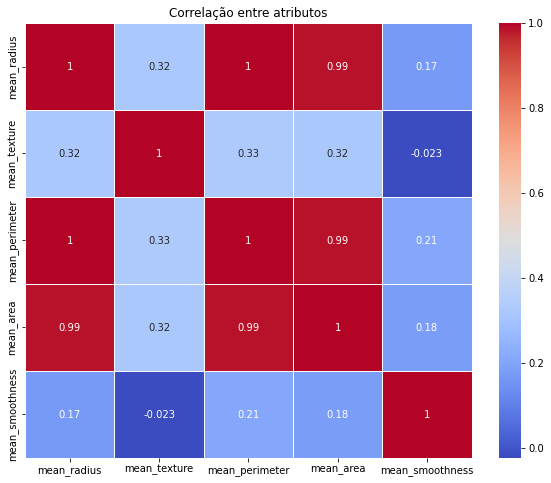

In [5]:
corr_matrix = df.iloc[:, :5].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlação entre atributos')
plt.show()

Normalização z-score

In [6]:
df.iloc[:, :5] = df.iloc[:, :5].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,1.096100,-2.071512,1.268817,0.983510,1.567087,0
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,0
2,1.578499,0.455786,1.565126,1.557513,0.941382,0
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,0
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0
...,...,...,...,...,...,...
564,2.109139,0.720838,2.058974,2.341795,1.040926,0
565,1.703356,2.083301,1.614511,1.722326,0.102368,0
566,0.701667,2.043775,0.672084,0.577445,-0.839745,0
567,1.836725,2.334403,1.980781,1.733693,1.524426,0


In [7]:
features = df[['mean_texture', 'mean_area', 'mean_smoothness']]
label = df[['diagnosis']]

## Método de Newton-Raphson

In [49]:
def logistic_function(z):
    # The logistic function
    return 1 / (1 + np.exp(-z))
    #return expit(z)

In [50]:
class LogisticRegression:
    
    def __init__(self, X, y):
        # self.X = X 
        self.X = np.c_[np.ones(X.shape[0]), X]     # Matriz de desenho nxp com coluna de 1's adicional (intercepto)
        self.y = y                              # Matriz de rótulos nx1
        self.theta = np.zeros((self.X.shape[1], 1))  # Inicia parâmetros como vetor nulo
    
    def newton_raphson(self, n_iter=100, norm=False, threshold=1e-6):
        n_samples = self.X.shape[0]
        for _ in range(n_iter):
            z = np.dot(self.X, self.theta)
            p = logistic_function(z)
            
            gradient = np.dot(self.X.T, (p - self.y))   # Matriz Gradiente
            p_ravel = p.ravel()                         # Tranforma o shape de p de (N, 1) para (N,)
            Hessian = np.dot(self.X.T, np.dot(np.diag(p_ravel * (1 - p_ravel)), self.X))  # Matriz Hessiana: X'WX, onde W = diag(p*(1-p))
            
            if norm:
                gradient /= n_samples
                Hessian /= n_samples
            
            #delta = np.linalg.solve(Hessian, gradient)
            delta = np.dot(np.linalg.inv(Hessian), gradient)
            self.theta -= delta
            
            if np.linalg.norm(delta) < threshold: break
        
        return self.theta

In [51]:
X = features.to_numpy()
y = label.to_numpy()

In [52]:
model = LogisticRegression(X, y)
coefs = model.newton_raphson()
coefs

array([[ 0.47738296],
       [-1.63902361],
       [-5.72216619],
       [-2.0641443 ]])

## Comparação com Statsmodels

In [54]:
X = np.c_[np.ones(X.shape[0]), X]

logit_model=  sm.Logit(y,X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.160394
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  569
Model:                          Logit   Df Residuals:                      565
Method:                           MLE   Df Model:                            3
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                  0.7571
Time:                        14:23:14   Log-Likelihood:                -91.264
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                5.529e-123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4774      0.206      2.322      0.020       0.074       0.880
x1            -1.6390      0.

## Resultados

É possível Observar que o algoritmo implementado obteve exatamente os mesmos valores para os coeficientes que o método implementado pela biblioteca statsmodels:

* Coeficientes pelo método implementados:
$$\theta_{0} = 0.47738296, \theta_{1} = -1.63902361, \theta_{2} = -5.72216619, \theta_{3} = -2.0641443$$ 

* Coeficientes pelo statsmodels:
$$\theta_{0} = 0.4774, \theta_{1} = -1.6390, \theta_{2} = -5.7222, \theta_{3} = -2.0641$$ 